# Value of Water Hedonic Regression Notebook

To build our hedonic regression model for the economic value of water inherent in the value of agricultural land we focused on Fresno County, CA as our sample area given its large amount of agricultural land parcels and the availability of relevant data. 

In order to hypothesize a measurable valuation of water we considered two variables related to water and land that we could measure: water sources and water uses

In our model we operate under the assumptions that where water comes from and how it is distributed effects the value it has to land (e.g. distance it travels to land and whether or not the land is irrigated) in addition to how much is used and how water is used on the land (e.g. water used for cultivating crops can be related to the revenue from the sales of those crops)

Our water source data includes:
- Water rights data, which we use to measure the distance from water sources to each agricultural land parcel

Our water uses data is compiled from:
- Crop overlay and water use data, which allows us to approximate a total minimum water use on each agricultural land parcel, productivity in revenue by acre foot of water used (based on crop water usage, yield, and sales revenue per agricultural land parcel)

We then considered the control variables necessary to help isolate simulated value in the model. This includes soil quality and land parcel data which contains improvements to land, land size, land use classification for agricultral land parcels, and soil quality.  

We built our dataset around the land parcel data becuase it allowed us to compile our feature set by land parcel which was a requirement for the web tool we built for leveraging our regression model results. 



In [2]:
import numpy as np
from scipy import interpolate
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get
import json
from collections import Counter
import re
import os
from dateutil.parser import parse
import operator
from uuid import uuid4
import sys
import geopandas
import shapefile
import probscale
import seaborn as sns

#from regressors import stats

In [3]:
from scipy.special import comb 
from sklearn import metrics,linear_model
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Dataset Aggregation

The data we are using in our dataset has been compiled from:
- 
- 
- 
- 


In [102]:
#load in data
landdata_location = 'data/joined_combined_filtered_mined_soil_water_df_td_13_4.csv'
#waterusagedata_location = 'data/'
cropdata_location = 'data/cacropyielddata.csv'
#soildata_location1 = 'data/soil_data_east.csv'
#soildata_location2 = 'data/soil_data_west.csv'
#soildata_location3 = 'data/soil_data_750.csv'
#soildata_location4 = 'data/soil_data_740.csv'

ld = pd.read_csv(landdata_location)


### Land Parcel Data

The land dataset we are using here is a compilation of Landgrids us parcel data for fresno county, crop yeild data from ____ and ___ from ____

First we need to examine the variables in our land data and remove and select our land features of potential interest. 

In [103]:
ld.describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,geoid,sourceagent,improvval,landval,parval,mail_addstr,homeowner_exemp,...,nirrcapcl,castorieindex,CropETo,WaterApplied,NetWaterUse_Applied,Factor,AppliedFromETo,AppliedWater,TotalWater,water_dist
count,25342.000000,25342.000000,25342.000000,25342.0,0.0,2.270600e+04,2.270600e+04,2.270600e+04,0.0,22706.000000,...,24051.000000,23583.000000,23081.000000,8521.000000,17720.000000,18408.000000,23081.000000,25342.000000,25342.000000,25342.000000
mean,12670.500000,12670.500000,12653.044866,6019.0,NaN,2.044906e+05,1.821032e+05,3.971233e+05,NaN,968.937946,...,4.637978,67.803248,2.721640,2.691810,2.642999,0.715431,2.821391,2.732964,3.799631,11.359627
std,7315.749597,7315.749597,7297.576590,0.0,NaN,5.281402e+05,2.789549e+05,8.606946e+05,NaN,2422.772977,...,1.204787,27.120829,0.571238,0.534447,0.953045,0.110369,0.816054,0.779756,0.779756,6.090116
min,0.000000,0.000000,0.000000,6019.0,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000,...,3.000000,1.000000,1.568333,0.600000,1.372093,0.428173,1.173810,0.600000,1.666667,0.125373
25%,6335.250000,6335.250000,6334.250000,6019.0,NaN,2.019400e+04,4.766700e+04,1.079668e+05,NaN,0.000000,...,4.000000,46.000000,2.303333,2.500000,1.860000,0.676627,2.223810,1.860000,2.926667,6.115502
50%,12670.500000,12670.500000,12663.500000,6019.0,NaN,9.008800e+04,1.027580e+05,2.265005e+05,NaN,0.000000,...,4.000000,76.000000,2.876667,2.700000,2.367052,0.708955,3.042857,2.700000,3.766667,11.903961
75%,19005.750000,19005.750000,18967.750000,6019.0,NaN,2.005930e+05,2.047005e+05,4.151655e+05,NaN,0.000000,...,4.000000,90.000000,3.257500,2.900000,3.537037,0.786568,3.586905,3.537037,4.603704,15.470906
max,25341.000000,25341.000000,25285.000000,6019.0,NaN,1.990775e+07,9.230949e+06,5.226432e+07,NaN,21000.000000,...,8.000000,100.000000,3.771667,4.500000,5.044273,1.229223,4.321429,4.530405,5.597072,34.048164


In [104]:
print('Number of colums:', len(ld.columns.tolist()))
print(', '.join(ld.columns.tolist()))

Number of colums: 105
Unnamed: 0, Unnamed: 0.1, Unnamed: 0_x, geoid, sourceagent, parcelnumb, usecode, improvval, landval, parval, owner, owner2, mailadd, mail_addstr, mail_city, mail_state2, mail_zip, address, saddno, saddpref, saddstr, saddsttyp, sunit, scity, original_address, city, county, state2, szip, address_source, legaldesc, path, ll_uuid, ll_updated_at, homeowner_exemp, lot_area, pers_prop_val, tax_area_code, contract_number, contract_year, non_renewal_year, use_high_best, use_secondary, qoz, qoz_tract, ll_gisacre, lng, lat, gdfindex, Acres_x, Crop2016_x, DWR_revise, Symb_class, MULTIUSE, CLASS1, SPECOND1, PCNT1, CLASS2, SUBCLASS2, SPECOND2, IRR_TYP2PA, UCF_ATT, CROPTYP1, CROPTYP2, Region, Acres, County, Crop2016, GlobalID, Shape_Leng, Shape_Area, land, imps, pp, mhome, tot, pnumb, firstfloor, secondfloor, addsize, tra, loc, bclass, year, gize, pool, psize, Unnamed: 0_y, intersect_area_acre, MUSYM, farmlndcl, irrcapcl, irrcapscl, nirrcapcl, nirrcalscl, castorieindex, Crop, Cr

We have 101 potential features in our land dataset, however there are 16 columns related to the mailing address which are not valuable to our regression analysis. We also don't need the legal description(legaldesc) for example. 

The features of relevance to our analysis include, parcel number (for merging our california crop yeild data and water rights, acreage (parcel size), crop (mapped to the parcel using arcgis and crop overlay data for Fresno County), the value of buildings on the parcel (firstfloor, secondfloor, addsize, gize), whether or not the parcel has a pool (as a proxy for purely residential land use). 

With respect to creating methods for measuring water access we are interested in the if the land is or isn't irrigated, the type of irrigation, water applied, net water use, total water available, and water distance

In [105]:
#select features of interest
land_data = ld[['parcelnumb', 'szip', 'county', 'landval', #parcel identifiers
                'll_gisacre', #parcel size in acres
                'Crop2016', #parcel crop
                'firstfloor', 'secondfloor', 'gize', 'pool', #building information for parcel
                'farmlndcl', 'irrcapcl', 'nirrcapcl',  'nirrcalscl', 'castorieindex', #parcel irrigation data
                'TotalWater', 'water_dist']] #total applied water in acre feet of water based on crop

#remove all na values s

In [106]:
print(len(land_data))
land_data.head()

25342


,parcelnumb,szip,county,landval,ll_gisacre,Crop2016,firstfloor,secondfloor,gize,pool,farmlndcl,irrcapcl,nirrcapcl,nirrcalscl,castorieindex,TotalWater,water_dist
0,37002003,93654-9320,fresno,207423.0,16.97049,Grapes,0.0,0.0,0.0,False,Prime farmland if irrigated,2.0,4.0,s,95.0,2.926667,11.698670
1,36309061,93654-9635,fresno,47692.0,8.68291,Miscellaneous Deciduous,1148.0,0.0,0.0,False,Farmland of statewide importance,3.0,4.0,s,45.0,4.360258,8.498322
2,05326007T,93656,fresno,NaN,11.46775,Almonds,NaN,NaN,NaN,False,Prime farmland if irrigated and drained,2.0,4.0,s,86.0,4.603704,7.014496
3,30932018,93657-9406,fresno,97978.0,20.13240,Miscellaneous Truck Crops,0.0,0.0,0.0,False,Prime farmland if irrigated,3.0,4.0,e,72.0,3.223960,1.441799
4,00124003,93620-9451,fresno,16825.0,6.81335,Cotton,1920.0,0.0,440.0,False,NaN,NaN,NaN,NaN,NaN,4.061667,9.344364


For the purposes of our analysis we decided to drop the na values for all records in our dataset instead of imputing them in some columns and dropping others. Given the methods of aggregation that went into our source data -- for much of the land data, based on county assessors in Fresno and for our crop data, based on crop map overlays -- imputing missing information could misrepresent the variability in our model.

In [107]:
land_data.dropna(inplace=True)

print(len(land_data))

20638


After removing nan values we lost 4704 records, about 18% of the land dataset. We then turned our attention to folding in our crop yield data 

### Crop Yield Data

In [108]:
#first load in crop yield data
crop_yield = pd.read_csv(cropdata_location)

In [109]:
print(', '.join(crop_yield.columns.tolist()))

Commodity, Planted All Purpose Acres, Harvested Acres, Yield, Production, Price per Unit, Value of Production in Dollars, Crop Unit Vale ($/acre


From the crop yield data, we took the unit price of a crop per acre ('Crop Unit Vale ($/acre') for calculating parcel specific crop production values in dollars and a water productivity measurement (see below).

In order to do that we matched our land data crops to the crops in the California crop yield dataset.<sup>1</sup>

____
<sup>1</sup> Citation needed

In [110]:
#crop yield crops
ca_crops = set(crop_yield['Commodity'].tolist())
               
print('CA crop yield crops:\n\t', ', '.join(sorted(ca_crops)))

CA crop yield crops:
	 ALFALFA, ALMONDS, APPLES, APRICOTS, ARTICHOKES, ARTICHOKES, FRESH MARKET, ARTICHOKES, UTILIZED, ASPARAGUS, ASPARAGUS, FRESH MARKET, ASPARAGUS, UTILIZED, BARLEY, BEANS, SNAP, BEANS, SNAP, FRESH MARKET, BEANS, SNAP, PROCESSING, BEANS, SNAP, UTILIZED, BROCCOLI, BROCCOLI, FRESH MARKET, BROCCOLI, PROCESSING, BROCCOLI, UTILIZED, CABBAGE, CABBAGE, FRESH MARKET, CABBAGE, PROCESSING, CABBAGE, UTILIZED, CARROTS, CARROTS, FRESH MARKET, CARROTS, PROCESSING, CARROTS, UTILIZED, CAULIFLOWER, CAULIFLOWER, FRESH MARKET, CAULIFLOWER, PROCESSING, CAULIFLOWER, UTILIZED, CELERY, CELERY, FRESH MARKET, CELERY, PROCESSING, CELERY, UTILIZED, CHERRIES, SWEET, CHICKPEAS, CORN, CORN, GRAIN, CORN, SILAGE, COTTON, COTTON, COTTONSEED, COTTON, PIMA, COTTON, UPLAND, CUCUMBERS, CUCUMBERS, FRESH MARKET, CUCUMBERS, PROCESSING, CUCUMBERS, UTILIZED, GARLIC, GARLIC, FRESH MARKET, GARLIC, PROCESSING, GARLIC, UTILIZED, GRAPEFRUIT, GRAPEFRUIT, FRESH MARKET, GRAPEFRUIT, PROCESSING, GRAPEFRUIT, UTILIZED, G

In [111]:
#land data crop list
land_data['Crop2016'] = land_data['Crop2016'].str.upper()
land_crops = set(land_data['Crop2016'].tolist())
print('Land Dataset crops:\n\t', ', '.join(sorted(land_crops)))

Land Dataset crops:
	 ALFALFA AND ALFALFA MIXTURES, ALMONDS, APPLES, BEANS (DRY), BUSH BERRIES, CARROTS, CHERRIES, CITRUS, COLE CROPS, CORN, SORGHUM AND SUDAN, COTTON, DATES, FLOWERS, NURSERY AND CHRISTMAS TREE FARMS, GRAPES, GREENHOUSE, KIWIS, LETTUCE/LEAFY GREENS, MELONS, SQUASH AND CUCUMBERS, MISCELLANEOUS DECIDUOUS, MISCELLANEOUS GRAIN AND HAY, MISCELLANEOUS GRASSES, MISCELLANEOUS SUBTROPICAL FRUITS, MISCELLANEOUS TRUCK CROPS, MIXED PASTURE, OLIVES, ONIONS AND GARLIC, PEACHES/NECTARINES, PEARS, PEPPERS, PISTACHIOS, PLUMS, PRUNES AND APRICOTS, POMEGRANATES, RICE, SAFFLOWER, STRAWBERRIES, SUNFLOWERS, TOMATOES, WALNUTS, WHEAT, YOUNG PERENNIALS


In [112]:
overlap = land_crops.intersection(ca_crops)
print('Overlap:', ', '.join(overlap))

Overlap: ALMONDS, APPLES, SAFFLOWER, GRAPES, CARROTS, WHEAT, RICE, COTTON, TOMATOES, PEARS


While there is a good amount of overlap the California crop yield dataset had more crops, some extra text that preveneted a match, and some groupings that intersected a single crop in our land data so we had to make some decisions about which to include.  

In [113]:
land_remaining = land_crops - overlap

ca_remaining = ca_crops - overlap

print('Crops not matched in land dataset:\n', ', '.join(sorted(list(land_remaining))), '\n')

print('Crops left in the california crop dataset:\n', ', '.join(sorted(list(ca_remaining))))


Crops not matched in land dataset:
 ALFALFA AND ALFALFA MIXTURES, BEANS (DRY), BUSH BERRIES, CHERRIES, CITRUS, COLE CROPS, CORN, SORGHUM AND SUDAN, DATES, FLOWERS, NURSERY AND CHRISTMAS TREE FARMS, GREENHOUSE, KIWIS, LETTUCE/LEAFY GREENS, MELONS, SQUASH AND CUCUMBERS, MISCELLANEOUS DECIDUOUS, MISCELLANEOUS GRAIN AND HAY, MISCELLANEOUS GRASSES, MISCELLANEOUS SUBTROPICAL FRUITS, MISCELLANEOUS TRUCK CROPS, MIXED PASTURE, OLIVES, ONIONS AND GARLIC, PEACHES/NECTARINES, PEPPERS, PISTACHIOS, PLUMS, PRUNES AND APRICOTS, POMEGRANATES, STRAWBERRIES, SUNFLOWERS, WALNUTS, YOUNG PERENNIALS 

Crops left in the california crop dataset:
 ALFALFA, APRICOTS, ARTICHOKES, ARTICHOKES, FRESH MARKET, ARTICHOKES, UTILIZED, ASPARAGUS, ASPARAGUS, FRESH MARKET, ASPARAGUS, UTILIZED, BARLEY, BEANS, SNAP, BEANS, SNAP, FRESH MARKET, BEANS, SNAP, PROCESSING, BEANS, SNAP, UTILIZED, BROCCOLI, BROCCOLI, FRESH MARKET, BROCCOLI, PROCESSING, BROCCOLI, UTILIZED, CABBAGE, CABBAGE, FRESH MARKET, CABBAGE, PROCESSING, CABBAGE, 

We adjusted the labeling for alfalfa, beans, corn, lettuce, 'melons, squash, and cucumber', miscellaneous grain and hay, garlic, peaches, prunes and apricots, potatoes and sweet potatoes, sunflower. Where there were seemingly duplicate crop records, we made sure to select the crop data containing a 'Price per Unit' value.

In [114]:
land_data = land_data.replace({'ALFALFA AND ALFALFA MIXTURES':'ALFALFA', 'BEANS (DRY)': 'BEANS, SNAP', 
            'CORN, SORGHUM AND SUDAN':'CORN, GRAIN', 'LETTUCE/LEAFY GREENS':'LETTUCE, HEAD', 
            'MISCELLANEOUS GRAIN AND HAY': 'HAY, (EXCL ALFALFA)', 'ONIONS AND GARLIC': 'GARLIC', 
            'PEACHES/NECTARINES': 'PEACHES', 'PLUMS, PRUNES AND APRICOTS': 'PRUNES', 
            'POTATOES AND SWEET POTATOES': 'POTATOES', 'SUNFLOWERS': 'SUNFLOWER', 'TOMATOES': 'TOMATOES, IN THE OPEN', 
            'COTTON': 'COTTON, COTTONSEED', 'CHERRIES':'CHERRIES, SWEET', 'SQUASH AND CUCUMBERS': 'SQUASH', })



We then looked at the overlap again and dropped the rows that dont overlap

In [115]:
newland_crops = set(land_data['Crop2016'].tolist())

overlap = newland_crops.intersection(ca_crops)
print('Matched:', overlap)

Matched: {'ALMONDS', 'CORN, GRAIN', 'APPLES', 'TOMATOES, IN THE OPEN', 'SAFFLOWER', 'GRAPES', 'CARROTS', 'PRUNES', 'WHEAT', 'BEANS, SNAP', 'COTTON, COTTONSEED', 'HAY, (EXCL ALFALFA)', 'GARLIC', 'CHERRIES, SWEET', 'RICE', 'ALFALFA', 'LETTUCE, HEAD', 'PEACHES', 'SUNFLOWER', 'PEARS'}


In [116]:
incrop = list(overlap)

available_crops = land_data['Crop2016'].isin(incrop)

land_matched = land_data[available_crops]

In [117]:
len(land_matched)

14429

With the available crop data we were able to match 14,429 records to our California crop yield data. 

In [118]:
#get matched crops in ca crop yield

available_commodity = crop_yield['Commodity'].isin(incrop)

ca_crops = crop_yield[available_commodity]



In [119]:
#rename columns to merge

ca_crops.rename(columns = {'Commodity': 'FinalCrop'}, inplace=True)
merge_crops = ca_crops[['FinalCrop', 'Crop Unit Vale ($/acre']]

land_matched.rename(columns = {'Crop2016': 'FinalCrop'}, inplace=True)




In [120]:
#now merge

full_set = land_matched.merge(merge_crops, on='FinalCrop')

Checking to see if values were merged in 


In [121]:
print(full_set.iloc[0]['FinalCrop'])
print(full_set.iloc[0]['Crop Unit Vale ($/acre'])


GRAPES
5840.0


## Feature Engineering

Based on our hypothesized value of water variables we thought the 'minimimum available water per parcel' would be helpful in our analysis in addition to the 'minimum water revenue per parcel'.


We also wanted to explore whether or not 'water productivity'<sup>1</sup>- the economic value produced per acre-foot of water applied to the parcel crop, as measured in dollars per acre-foot - would be a good proxy for waters value as it relates to land value. 

We also wanted to see if controlling for the total monetary value of crops producable per parcel would be helpful in the model. 


____
<sup>1</sup> citation needed

Now we add two columns to our dataset to hold our applied water in millions of acre feet and our water productivity column and fill in both

In [122]:
full_set['crop_rev'] = None
full_set['water_productivity'] = None
full_set['min_avail_water'] = None
full_set['min_water_rev'] = None

The 'crop_rev' feature is the total monetary value of crops per parcel using crop unit value * parcel acres where crop unit value is derived from the per crop CA total production in revenue divided by total harvested acres in the california crop yield dataset. 

We recognize this method is a bit crude given that not all acres on a given parcel are used entirely for cultivating crops. For the purposes of this exploration we created the measurement to look at its potential benefit in our analysis. 

In [123]:
full_set['Crop Unit Vale ($/acre'] = full_set['Crop Unit Vale ($/acre'].astype('float64')



for i, r in full_set.iterrows():
    full_set.at[i,'crop_rev'] = r['Crop Unit Vale ($/acre'] * r['ll_gisacre']
    

The 'water_productivity' feature is the parcel crop revenue value per acre divided by the total water per acre of applied water to the crop. 

In [124]:

for i, r in full_set.iterrows():


    #divide millions by millions to get a revenue per acre feet of water applied
    converted = r['TotalWater'] * 1000000

    full_set.at[i, 'water_productivity'] = float(r['crop_rev'])/converted

  
full_set['water_productivity'] = full_set['water_productivity'].astype('float64')

In [125]:
full_set['water_productivity'].head()

0    0.033864
1    0.071694
2    0.314373
3    0.026831
4    0.077111
Name: water_productivity, dtype: float64

The minimum water available per parcel was derved using the acre feet applied per crop * parcel acreage

In [126]:
for i, r in full_set.iterrows():

    
    full_set.at[i, 'min_avail_water'] = r['TotalWater'] * r['ll_gisacre'] 

full_set['min_avail_water'] = full_set['min_avail_water'].astype('float64')

In [127]:
full_set['min_avail_water'].head()

0     49.666967
1    105.151621
2    461.082900
3     39.351989
4    113.096673
Name: min_avail_water, dtype: float64

We then used the water productivity value to get a potential revenue total value from the number of acres. We took our min_avail_water in acre-feet and multiplied that by our water productivity value to get a min water revenue in dollars.

In [128]:
for i, r in full_set.iterrows():

    full_set.at[i, 'min_water_rev'] = r['min_avail_water'] * r['water_productivity'] 
    

full_set['min_water_rev'] = full_set['min_water_rev'].astype('float64')

In [129]:
full_set['min_water_rev']

0          1.681906
1          7.538731
2        144.952048
3          1.055844
4          8.720994
            ...    
14424      0.009663
14425      0.620649
14426      0.009145
14427      0.177085
14428      0.011488
Name: min_water_rev, Length: 14429, dtype: float64

Given that we are focusing on agricultural land we decided to remove the parcels which had the presence of a swimming pool, as they denoted a residential use for the parcel

In [130]:

#exclude pools
full_set.drop(full_set[full_set['pool'] == True].index, inplace=True)



In [131]:
full_set['pool']

0        False
1        False
2        False
3        False
4        False
         ...  
14424    False
14425    False
14426    False
14427    False
14428    False
Name: pool, Length: 13630, dtype: bool

In [132]:
set(full_set['farmlndcl'].tolist())

{'Farmland of statewide importance',
 'Not prime farmland',
 'Prime farmland if irrigated',
 'Prime farmland if irrigated and drained',
 'Prime farmland if irrigated and either protected from flooding or not frequently flooded during the growing season',
 'Prime farmland if irrigated and reclaimed of excess salts and sodium'}

Lets do some work on the land value by summing building land size and excluding those records with a pool

## Feature Analysis

After compiling our data we wanted to conduct some univariate and bivariate analysis on our variables to see what has potential in regression analysis. 


In [133]:
print('Featureset:', ', '.join(full_set.columns))

Featureset: parcelnumb, szip, county, landval, ll_gisacre, FinalCrop, firstfloor, secondfloor, gize, pool, farmlndcl, irrcapcl, nirrcapcl, nirrcalscl, castorieindex, TotalWater, water_dist, Crop Unit Vale ($/acre, crop_rev, water_productivity, min_avail_water, min_water_rev


In [134]:
full_set.describe()

,landval,ll_gisacre,firstfloor,secondfloor,gize,irrcapcl,nirrcapcl,castorieindex,TotalWater,water_dist,Crop Unit Vale ($/acre,water_productivity,min_avail_water,min_water_rev
count,1.363000e+04,13630.000000,13630.000000,13630.000000,13630.000000,13630.000000,13630.000000,13630.000000,13630.000000,13630.000000,11744.000000,11744.000000,13630.000000,1.174400e+04
mean,1.838440e+05,46.708659,1107.571827,26.857594,162.871900,2.265371,4.587968,71.537417,3.684189,11.969699,5201.802976,0.066903,180.212053,4.585257e+01
std,2.704524e+05,81.421718,7435.743812,177.635441,859.455181,0.876527,1.150181,25.870165,0.777842,5.658416,2212.243147,0.133574,329.043107,2.291858e+02
min,0.000000e+00,0.007320,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,2.438760,0.279622,363.409836,0.000002,0.021423,7.546136e-08
25%,5.150525e+04,4.749678,0.000000,0.000000,0.000000,2.000000,4.000000,57.000000,2.926667,7.224683,5840.000000,0.004171,17.502717,7.796189e-02
50%,1.078085e+05,19.569145,0.000000,0.000000,0.000000,2.000000,4.000000,77.000000,3.600193,12.649338,5840.000000,0.031773,72.781438,2.173540e+00
75%,2.100220e+05,40.531590,1296.000000,0.000000,0.000000,3.000000,4.000000,95.000000,4.603704,15.673171,6176.250000,0.072815,173.037101,9.167945e+00
max,8.312000e+06,918.587540,408030.000000,4944.000000,67200.000000,6.000000,7.000000,100.000000,5.597072,33.513405,12121.370370,2.311442,3645.871531,5.039807e+03


mean values for land, acreage, water dist, min avail water

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1299533c8>,
      dtype=object)

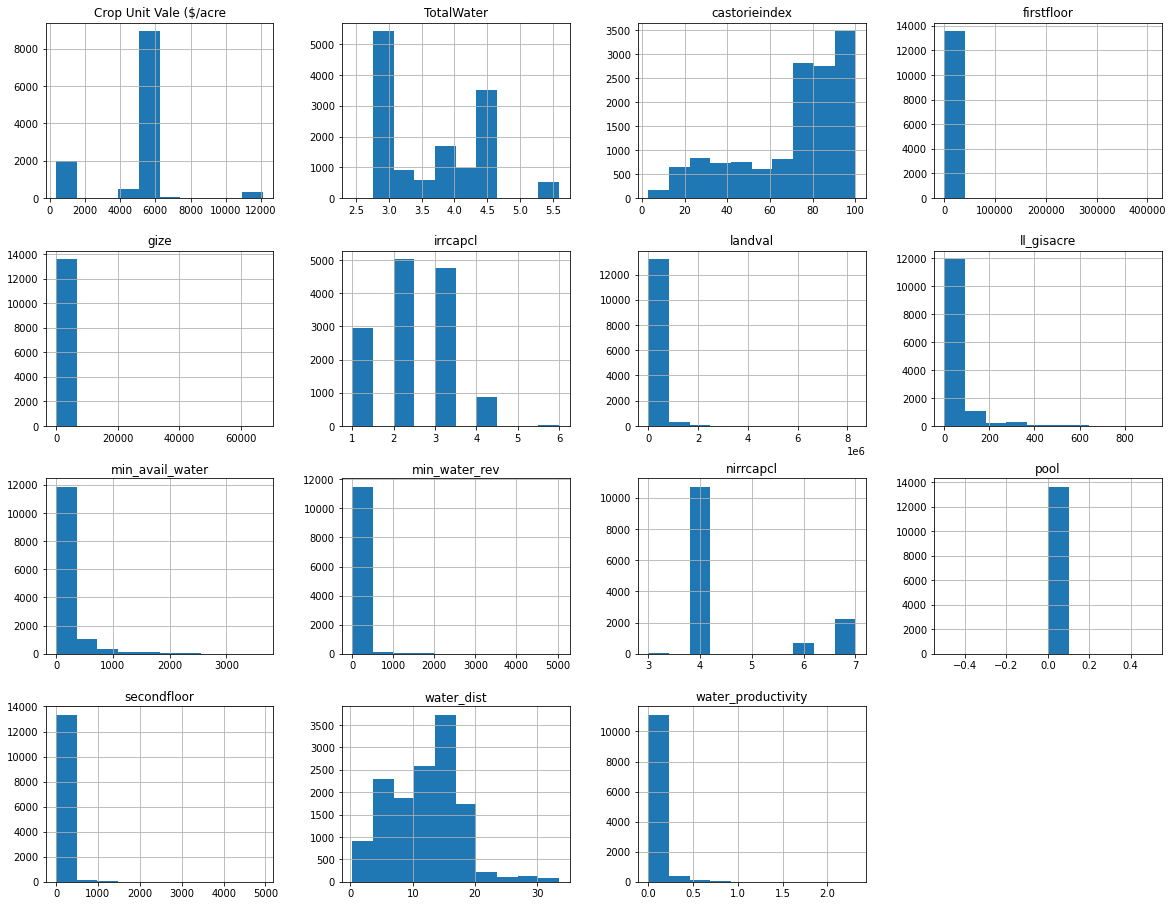

In [135]:
full_set.hist(layout=(5,4), figsize=(20,20), bins=10)

Noticeably our water distane metric is the only regularly distributed feature set. Our target variable for regression, 'landval' (land value) is positive skewed along with most of our numerical features. To see if we can get a more normal distribution on those we will perform a log transformation

We also have some clear categorical features in 'farmlndcl', 'irrcapcl', 'nirrcapcl', and 'nirrcalscl' which have to do with irrigation 

We also have an ordinal feature with 'castorieindex'



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126c616a0>,
      dtype=object)

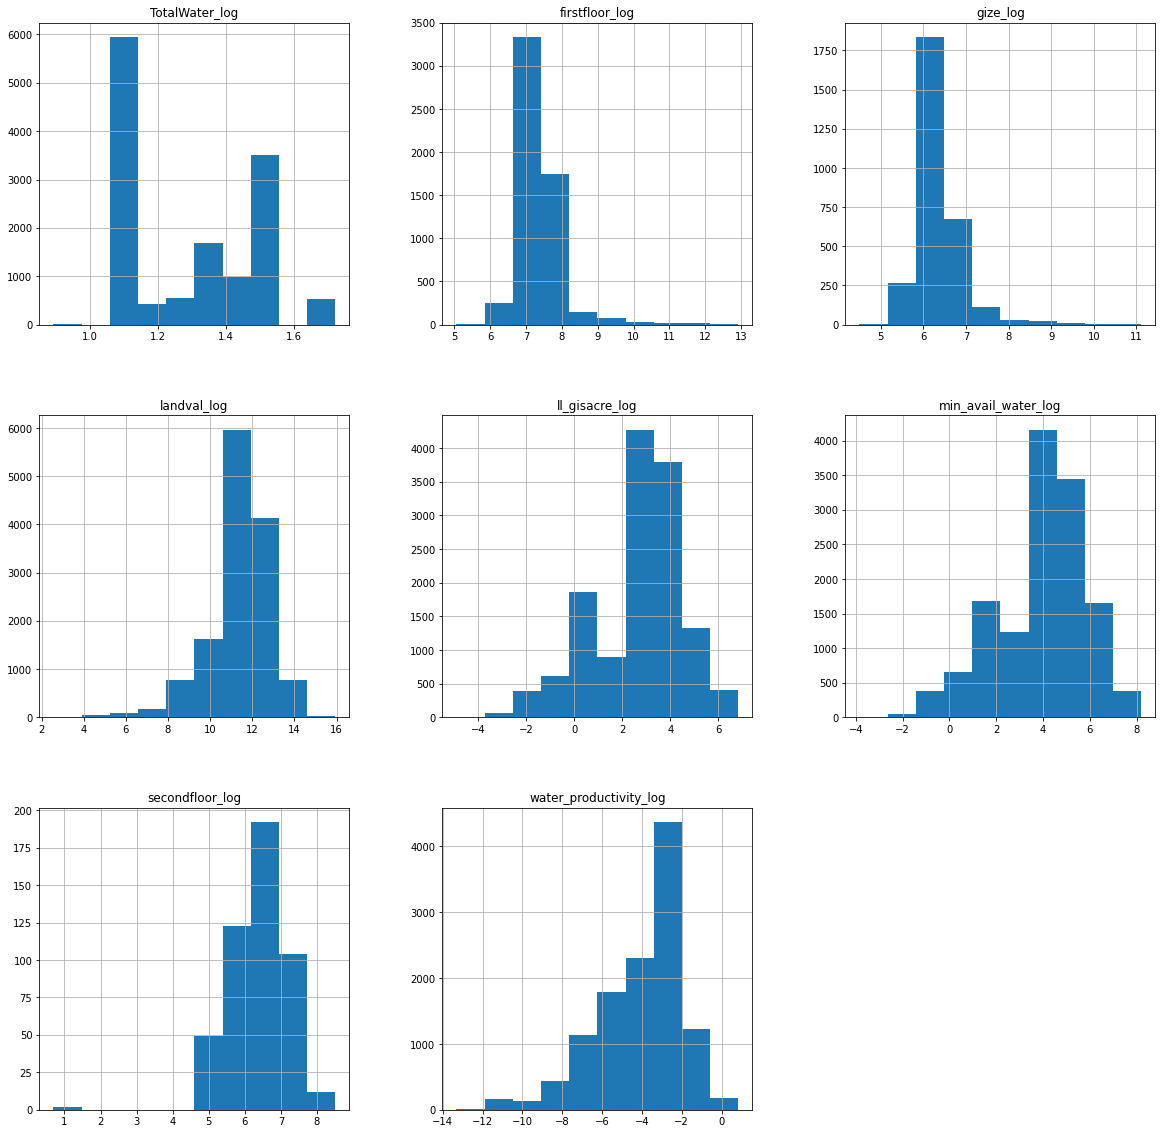

In [136]:
full_set['landval_log'] = np.log(full_set['landval'])
full_set['ll_gisacre_log'] = np.log(full_set['ll_gisacre'])
full_set['TotalWater_log'] = np.log(full_set['TotalWater'])
full_set['min_avail_water_log'] = np.log(full_set['min_avail_water'])
full_set['firstfloor_log'] = np.log(full_set['firstfloor'])
full_set['secondfloor_log'] = np.log(full_set['secondfloor'])
full_set['gize_log'] = np.log(full_set['gize'])
full_set['water_productivity_log'] = np.log(full_set['water_productivity'])


full_set[np.isfinite(full_set[['landval_log', 'TotalWater_log', 'min_avail_water_log', 'firstfloor_log', 'secondfloor_log', 'll_gisacre_log', 'gize_log', 'water_productivity_log']])][['landval_log', 'll_gisacre_log', 'TotalWater_log', 'min_avail_water_log', 'firstfloor_log', 'secondfloor_log','gize_log', 'water_productivity_log']].hist(figsize=(20,20), layout=(3,3))





After applying log transforms to our positively skewed numerical features we see a clear change in the distribution for land value, acreage, minimum water available, and the parcel building size features. 

We then turned to bivariate analysis to see their interactions in particular with land value. 

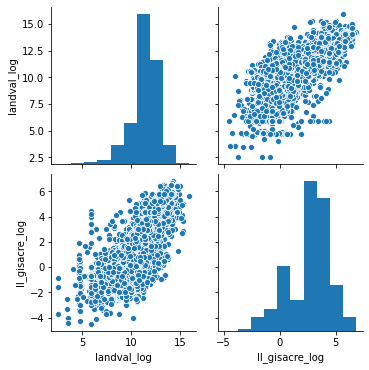

In [137]:
land_water_bivariate = full_set[['landval_log','ll_gisacre_log']]

sns.pairplot(land_water_bivariate[np.isfinite(land_water_bivariate[['landval_log', 'll_gisacre_log']])])
                       
                       

bivariate analysis on water productivity and land, acreage and land, total water and land, water distance and land, min avial water and land

## categorical data eda goes here

## Hedonic Regression Analysis

For our purposes we want to use the following features for hedonic 
regression:

- landval: parcel land value, based on assessor
- ll_gisacre: parcel acreage, as in size






Lets see how correlated the values are before we try and regress them.

In [138]:
full_set.corr()

,landval,ll_gisacre,firstfloor,secondfloor,gize,pool,irrcapcl,nirrcapcl,castorieindex,TotalWater,...,min_avail_water,min_water_rev,landval_log,ll_gisacre_log,TotalWater_log,min_avail_water_log,firstfloor_log,secondfloor_log,gize_log,water_productivity_log
landval,1.000000,0.636023,0.055569,-0.004404,0.013369,NaN,0.014708,0.111132,-0.099548,0.083858,...,0.620690,0.499762,0.635832,0.485586,0.086238,0.485878,0.067835,0.037105,0.100054,0.437473
ll_gisacre,0.636023,1.000000,-0.041015,-0.041044,-0.058248,NaN,-0.018587,0.372424,-0.196410,0.128355,...,0.975711,0.777544,0.513258,0.629641,0.132009,0.632214,-0.079280,0.049297,-0.044002,0.535776
firstfloor,0.055569,-0.041015,1.000000,0.157698,0.230662,NaN,-0.010666,-0.045505,0.031109,-0.020836,...,-0.040515,-0.022027,0.043133,-0.035464,-0.023326,-0.037336,0.613949,0.128572,0.320291,-0.030224
secondfloor,-0.004404,-0.041044,0.157698,1.000000,0.083014,NaN,-0.005836,-0.068546,0.042783,-0.016674,...,-0.040061,-0.021758,-0.001232,-0.059035,-0.017601,-0.059845,0.084228,0.817278,0.130390,-0.060314
gize,0.013369,-0.058248,0.230662,0.083014,1.000000,NaN,0.013886,-0.079587,0.041864,-0.037038,...,-0.058119,-0.029801,0.007282,-0.063312,-0.039134,-0.066383,0.257445,0.203711,0.620105,-0.042628
pool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
irrcapcl,0.014708,-0.018587,-0.010666,-0.005836,0.013886,NaN,1.000000,-0.030180,-0.605970,0.004293,...,-0.021617,-0.023000,0.002225,-0.008822,-0.000971,-0.008762,-0.046242,0.017332,-0.011400,-0.003651
nirrcapcl,0.111132,0.372424,-0.045505,-0.068546,-0.079587,NaN,-0.030180,1.000000,-0.347559,0.211335,...,0.371702,0.236149,0.054437,0.246367,0.221229,0.265810,0.044505,0.025730,-0.009789,0.162601
castorieindex,-0.099548,-0.196410,0.031109,0.042783,0.041864,NaN,-0.605970,-0.347559,1.000000,-0.182603,...,-0.202156,-0.108389,-0.042551,-0.104481,-0.185697,-0.122715,-0.022266,0.017052,0.019719,0.009969
TotalWater,0.083858,0.128355,-0.020836,-0.016674,-0.037038,NaN,0.004293,0.211335,-0.182603,1.000000,...,0.233726,0.048264,0.052356,0.116145,0.996920,0.222358,-0.013911,0.128051,0.011331,-0.015552


So no correlations that would suggest we shouldnt be using these variables.

In [143]:
# for the purposes of this first run we arent going to interpolate nan values, just drop them all 

full_set =full_set[~full_set.isin([np.nan, np.inf, -np.inf]).any(1)]

Now we are going to run a quick regression with equation:

landvalue (log of) = agricultural revenue (acreage X crop revenue per acre) + minimum water access+ minimum water revenue (min water access X water_productivity) + nirrcapcl + irracapcl + TotalWater + building size

In [167]:
y = full_set['landval']
y_ln = full_set['landval_log']



X_log = full_set[['ll_gisacre_log', 'water_productivity_log', 'min_avail_water_log', 'water_dist', 'min_water_rev']]

X = full_set[['ll_gisacre', 'water_productivity', 'min_avail_water', 'water_dist', 'min_water_rev']]


In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_ln, test_size=0.2, random_state=1)



In [187]:
#non log
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#scaler2 = StandardScaler()
#X_train = pd.DataFrame(scaler2.fit_transform(X_train), columns=X_train.columns)
#X_test = pd.DataFrame(scaler2.transform(X_test), columns=X_test.columns)

In [188]:
#log
scaler2 = StandardScaler()
X_log_train = pd.DataFrame(scaler2.fit_transform(X_log_train), columns=X_log_train.columns)
X_log_test = pd.DataFrame(scaler2.transform(X_log_test), columns=X_log_test.columns)

In [189]:
ols = LinearRegression()
ols.fit(X_train, y_train)
print("\n================ SUMMARY TABLE WITH P-VALUES for non transformed Target Variable =================")
print("R-squared:", ols.score(X_train, y_train))
print("Intercept:", ols.intercept_)
print("Coefficients:", ols.coef_)
print('\n')
xlabels = X.columns
#stats.describe(ols, X, y_ln, xlabels)
print(X_train)


================ SUMMARY TABLE WITH P-VALUES for Log Transformed Target Variable =================
R-squared: 0.7068956103756221
Intercept: 141919.24203821656
Coefficients: [ 285803.3141498     4926.28601049   30092.79124211  -19032.65280314
 -137248.21762628]


     ll_gisacre  water_productivity  min_avail_water  water_dist  \
0     -0.078397            0.128753        -0.114084    0.150555   
1     -0.370843           -0.581468        -0.279366   -1.549263   
2      0.107071            0.578438        -0.008964   -0.840618   
3     -0.302073           -0.413573        -0.240860    0.498575   
4      0.273341            0.981578         0.085276    1.159171   
..          ...                 ...              ...         ...   
152   -0.369883           -0.579903        -0.278510   -1.380857   
153   -0.033211           -0.031089         0.021654   -1.507944   
154   -0.196001           -0.156391        -0.180741    0.749155   
155   -0.338716           -0.529098        -0.250723   -

In [190]:
ols_log = LinearRegression()
ols_log.fit(X_log_train, y_log_train)
print("\n================ SUMMARY TABLE WITH P-VALUES for Log Transformed Target Variable =================")
print("R-squared:", ols_log.score(X_log_train, y_log_train))
print("Intercept:", ols_log.intercept_)
print("Coefficients:", ols_log.coef_)
print('\n')
x_loglabels = X_log.columns
#stats.describe(ols, X, y_ln, xlabels)
print(X_train)


================ SUMMARY TABLE WITH P-VALUES for Log Transformed Target Variable =================
R-squared: 0.5514747022705364
Intercept: 11.1875792034759
Coefficients: [-0.22771865  0.10485408  1.07198983 -0.26373292  0.08196466]


     ll_gisacre  water_productivity  min_avail_water  water_dist  \
0     -0.078397            0.128753        -0.114084    0.150555   
1     -0.370843           -0.581468        -0.279366   -1.549263   
2      0.107071            0.578438        -0.008964   -0.840618   
3     -0.302073           -0.413573        -0.240860    0.498575   
4      0.273341            0.981578         0.085276    1.159171   
..          ...                 ...              ...         ...   
152   -0.369883           -0.579903        -0.278510   -1.380857   
153   -0.033211           -0.031089         0.021654   -1.507944   
154   -0.196001           -0.156391        -0.180741    0.749155   
155   -0.338716           -0.529098        -0.250723   -1.278740   
156   -0.349396 

In [191]:

# Collect the coefficients
df_ols_coef = pd.DataFrame(ols.coef_, index=X_train.columns, columns=['Coefficients'])
df_ols_coef['Coef_abs'] = df_ols_coef.Coefficients.abs()

df_ols_coef_log = pd.DataFrame(ols.coef_, index=X_log_train.columns, columns=['Coefficients'])
df_ols_coef_log['Coef_abs'] = df_ols_coef.Coefficients.abs()

In [192]:
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)

predictions_train_log = ols_log.predict(X_log_train)
predictions_test_log = ols_log.predict(X_log_test)

In [193]:
# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(ols, X_train, y_train, cv=5)
print('Non Transformed')
print('Training Score:', ols.score(X_train, y_train))
print('Cross validation scores:', cv_scores)
print('Mean cross validation score:', cv_scores.mean())
print('Test Score:', ols.score(X_test, y_test))

Non Transformed
Training Score: 0.7068956103756221
Cross validation scores: [-0.40190583  0.23733839  0.36802188  0.12927988  0.5499861 ]
Mean cross validation score: 0.1765440813458412
Test Score: 0.2655629635988137


In [194]:
cv_log_scores = cross_val_score(ols_log, X_log_train, y_log_train, cv=5)
print('Log Transformed')
print('Training Score:', ols.score(X_log_train, y_log_train))
print('Cross validation scores:', cv_log_scores)
print('Mean cross validation score:', cv_log_scores.mean())
print('Test Score:', ols_log.score(X_log_test, y_log_test))

Log Transformed
Training Score: -77668998563.63448
Cross validation scores: [0.59959392 0.40251697 0.02799227 0.60516878 0.50834797]
Mean cross validation score: 0.4287239833581335
Test Score: 0.37830786202601707


In [156]:
# Shuffled 5-fold cross validation scores are rather similar
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(ols, X_train, y_train, cv=kf)

print('Shuffled cross validation score:', cv_scores_shuffled)
print('Mean shuffled cross validation score:', cv_scores_shuffled.mean())

Shuffled cross validation score: [-0.34479518  0.24857417 -0.05209839  0.24335726  0.29258706]
Mean shuffled cross validation score: 0.07752498499483837


In [157]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_test)) 
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, predictions_test))**0.5)

Mean Squared Error: 37199201190.5598
Root Mean Squared Error: 192870.94439173516


In [158]:
ols_residuals = (y_train - predictions_train)
ols_residuals.describe()

count    1.570000e+02
mean     1.269817e-11
std      1.302964e+05
min     -3.279423e+05
25%     -5.510154e+04
50%     -2.989574e+04
75%      1.602907e+04
max      8.885040e+05
Name: landval, dtype: float64

In [159]:
print("Skew:", ols_residuals.skew())
print("Kurtosis:", ols_residuals.kurtosis())
stat, p = shapiro(ols_residuals)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: 4.082564112435602
Kurtosis: 23.348249229504944
Shapiro-Wilk test on normality=0.614, p=0.000


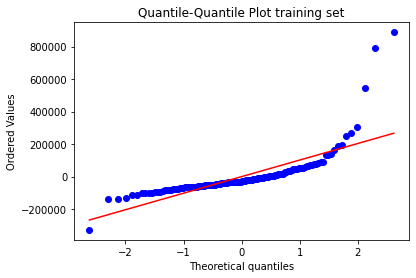

In [160]:
stats.probplot(ols_residuals, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot training set");

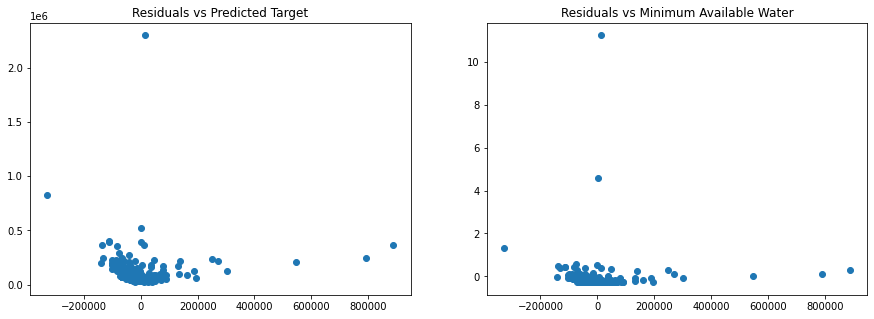

In [161]:

# Plotting the OLS residuals against the predicted-y and 'min_avail_water'. The residuals appear well-behaved
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].scatter(ols_residuals, predictions_train)
ax[0].set_title('Residuals vs Predicted Target', fontsize=12)

ax[1].scatter(ols_residuals, X_train.min_avail_water)
ax[1].set_title('Residuals vs Minimum Available Water', fontsize=12);

In [162]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_mod.alpha_)
print('Training score:', ridge_mod.score(X_train, y_train))
print("Test Score:", ridge_mod.score(X_test, y_test))

Best Ridge alpha: 2.782559402207126
Training score: 0.7033971959095553
Test Score: 0.2571917814218828


In [163]:
df_ridge_coef = pd.DataFrame(ridge_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_ridge_coef['Coef_abs'] = df_ridge_coef.Coefficients.abs()

In [164]:
# Confirmed similar to the above Ridge CV scores
ridge_mod = Ridge(alpha=2.78)

scores = cross_val_score(ridge_mod, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

ridge_mod.fit(X_train, y_train)
print("Training Score:", ridge_mod.score(X_train, y_train))
print("Test Score:", ridge_mod.score(X_test, y_test))

Cross-validated training scores: [ 0.84893734  0.22390677  0.43183071 -0.43243684  0.54236726]
Mean cross-validated training score: 0.322921047780727
Training Score: 0.7034013423940246
Test Score: 0.2572014477178871


In [165]:
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)
print('Training score:', lasso_mod.score(X_train, y_train))
print("Test Score:", lasso_mod.score(X_test, y_test))

Best Lasso alpha: 10000.0
Training score: 0.6683833962510723
Test Score: 0.23596112303507802


In [166]:
df_lasso_coef = pd.DataFrame(lasso_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_lasso_coef['Coef_abs'] = df_lasso_coef.Coefficients.abs()

In [69]:
coef = pd.concat([df_ols_coef['Coefficients'], df_ridge_coef['Coefficients'], df_lasso_coef['Coefficients']])
coef = pd.DataFrame(coef)
coef.reset_index(level=0, inplace=True)
coef.columns = ['variable', 'coefficient']


In [70]:
coef.loc[0:2, "model"] = "ols"
coef.loc[3:5, "model"] = "ridge"
coef.loc[6:9, "model"] = "lasso"

In [202]:
full_set.columns
output = full_set[['parcelnumb', 'county', 'szip', 'landval']]

In [203]:
#using log tranformed coefficients
full_set['water_val'] = full_set['landval'] * 0.10485408 + full_set['landval'] * 1.07198983 + full_set['landval'] *  -0.26373292 + full_set['landval'] *0.08196466

  

In [205]:
full_set.to_csv('fresno_watervalue_derived_4_15.csv', columns=('parcelnumb', 'county', 'szip', 'landval', 'water_val'))